<a id="top"></a><br>
# Table of Contents  
### 1. [Problem Statement](#1)
### 2. [Data Set Information](#2) 
### 3. [Exploratory Data Analysis and Visualization](#3) 
### 4. [Variable Selection](#4) 
### 5. [HyperParameter Tuning and Model Selection](#5) 

<a id="1"></a> 
<a href="#top">Back to top</a>
### $$\mathbf{\text{Part 1. Problem Statement:}}$$ 
<center>Estimating the precise number of occupants in a room using multiple non-intrusive environmental sensors like temperature, light, sound, CO2 and PIR.</center>

<a href="#top">Back to top</a>
<a id="2"></a> 
## Part 2. Data Set Information:

The experimental testbed for occupancy estimation was deployed in a 6m x 4.6m room. In this setup, there were 7 sensor nodes and one edge arranged in a star configuration, with the sensor nodes sending data to the edge every 30 seconds. No HVAC systems (Heating, Ventilation and Air-Conditioning) were in use while the dataset was being collected.

Five different types of non-intrusive sensors were used in this experiment: temperature, light, sound, CO2 and digital passive infrared (PIR). Sensor nodes S1-S4 consisted of temperature, light and sound sensors, S5 had a CO2 sensor and S6 and S7 had one PIR sensor each that were deployed on the ceiling ledges at an angle that maximized the sensor's field of view for motion detection.

The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.

## Attribute Information:

#### Categorical Variable:
- Date: YYYY/MM/DD
- Time: HH:MM:SS
- Room_Occupancy_Count: Ground Truth

#### Numerical Variables:
- Temperature: In degree Celsius
- Light: In Lux (*Lux is a measure of how much light falls on a particular surface*)
- Sound: In Volts (amplifier output read by ADC)
- CO2: In PPM
- CO2 Slope: Slope of CO2 values taken in a sliding window
- PIR: Binary value conveying motion detection


In [1]:
#Importing relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('room_occupancy_estimation_dataset.csv')

In [3]:
df.head()

Date      Time  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  \
0  2017/12/22  10:49:41    24.94    24.75    24.56    25.38       121   
1  2017/12/22  10:50:12    24.94    24.75    24.56    25.44       121   
2  2017/12/22  10:50:42    25.00    24.75    24.50    25.44       121   
3  2017/12/22  10:51:13    25.00    24.75    24.56    25.44       121   
4  2017/12/22  10:51:44    25.00    24.75    24.56    25.44       121   

   S2_Light  S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  \
0        34        53        40      0.08      0.19      0.06      0.06   
1        33        53        40      0.93      0.05      0.06      0.06   
2        34        53        40      0.43      0.11      0.08      0.06   
3        34        53        40      0.41      0.10      0.10      0.09   
4        34        54        40      0.18      0.06      0.06      0.06   

   S5_CO2  S5_CO2_Slope  S6_PIR  S7_PIR  Room_Occupancy_Count  
0     390      0.769231       0       0                     1  
1     390      0.646154       0       0                     1  
2     390      0.519231       0       0                     1  
3     390      0.388462       0       0                     1  
4     390      0.253846       0       0                     1

In [4]:
df.shape

(10129, 19)

<AxesSubplot:ylabel='Room_Occupancy_Count'>

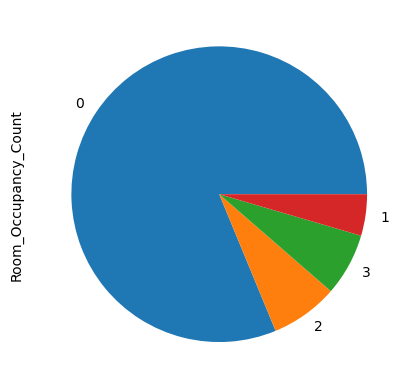

In [5]:
df['Room_Occupancy_Count'].value_counts().plot(kind='pie')

In this dataset, there are 10129 records with 18 input variables and one output variable, "Room_Occupancy_Count".

<a href="#top">Back to top</a>
<a id="3"></a> 
## Part 3. Exploratory data analysis (EDA) and Visualization :

## EDA:

#### 1. Checking for duplicates in the dataset

In [6]:
df[df.duplicated()]

Empty DataFrame
Columns: [Date, Time, S1_Temp, S2_Temp, S3_Temp, S4_Temp, S1_Light, S2_Light, S3_Light, S4_Light, S1_Sound, S2_Sound, S3_Sound, S4_Sound, S5_CO2, S5_CO2_Slope, S6_PIR, S7_PIR, Room_Occupancy_Count]
Index: []

There are no duplicate rows in our dataset.

In [7]:
df.drop(columns=['Date','Time'],axis=1, inplace=True)

In [8]:
df[df.duplicated()]

S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  \
1367     25.50    25.50    25.06    25.81         0         0         0   
1371     25.50    25.50    25.06    25.81         0         0         0   
1389     25.44    25.44    25.00    25.75         0         0         0   
1407     25.44    25.44    25.00    25.81         0         0         0   
1409     25.44    25.44    25.06    25.81         0         0         0   
...        ...      ...      ...      ...       ...       ...       ...   
10075    25.13    25.06    24.63    25.19         6         6        31   
10084    25.13    25.06    24.63    25.19         6         7        32   
10098    25.13    25.06    24.63    25.19         6         7        32   
10117    25.13    25.06    24.69    25.19         6         7        33   
10123    25.06    25.13    24.69    25.25         6         7        33   

       S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  \
1367          0      0.07      0.05      0.06      0.06     390      0.000000   
1371          0      0.07      0.05      0.06      0.06     390      0.000000   
1389          0      0.06      0.04      0.06      0.06     385     -0.288462   
1407          0      0.07      0.05      0.06      0.07     385      0.000000   
1409          0      0.07      0.05      0.06      0.06     385      0.000000   
...         ...       ...       ...       ...       ...     ...           ...   
10075        21      0.08      0.05      0.06      0.09     345      0.000000   
10084        21      0.08      0.05      0.05      0.08     345      0.000000   
10098        21      0.08      0.05      0.05      0.08     345      0.000000   
10117        22      0.08      0.05      0.06      0.09     345      0.000000   
10123        22      0.08      0.05      0.06      0.09     345      0.000000   

       S6_PIR  S7_PIR  Room_Occupancy_Count  
1367        0       0                     0  
1371        0       0                     0  
1389        0       0                     0  
1407        0       0                     0  
1409        0       0                     0  
...       ...     ...                   ...  
10075       0       0                     0  
10084       0       0                     0  
10098       0       0                     0  
10117       0       0                     0  
10123       0       0                     0  

[1301 rows x 17 columns]

After dropping the 'Date' and 'Time' columns, we notice that there are a   few duplicate values which were not present before. These columns need not be dropped as they are independent readings and not duplicates. 

#### 2. Checking for null values in the dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 10129 entries, 0 to 10128

Data columns (total 17 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   S1_Temp               10129 non-null  float64

 1   S2_Temp               10129 non-null  float64

 2   S3_Temp               10129 non-null  float64

 3   S4_Temp               10129 non-null  float64

 4   S1_Light              10129 non-null  int64  

 5   S2_Light              10129 non-null  int64  

 6   S3_Light              10129 non-null  int64  

 7   S4_Light              10129 non-null  int64  

 8   S1_Sound              10129 non-null  float64

 9   S2_Sound              10129 non-null  float64

 10  S3_Sound              10129 non-null  float64

 11  S4_Sound              10129 non-null  float64

 12  S5_CO2                10129 non-null  int64  

 13  S5_CO2_Slope          10129 non-null  float64

 14  S6_PIR                10129 non-null  int64  

 15 

We can see that there are no missing values in the dataset. 

#### 3. Visualizing and treating outliers

In [10]:
df.describe()

S1_Temp       S2_Temp       S3_Temp       S4_Temp      S1_Light  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      25.454012     25.546059     25.056621     25.754125     25.445059   
std        0.351351      0.586325      0.427283      0.356434     51.011264   
min       24.940000     24.750000     24.440000     24.940000      0.000000   
25%       25.190000     25.190000     24.690000     25.440000      0.000000   
50%       25.380000     25.380000     24.940000     25.750000      0.000000   
75%       25.630000     25.630000     25.380000     26.000000     12.000000   
max       26.380000     29.000000     26.190000     26.560000    165.000000   

          S2_Light      S3_Light      S4_Light      S1_Sound      S2_Sound  \
count  10129.00000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      26.01629     34.248494     13.220259      0.168178      0.120066   
std       67.30417     58.400744     19.602219      0.316709      0.266503   
min        0.00000      0.000000      0.000000      0.060000      0.040000   
25%        0.00000      0.000000      0.000000      0.070000      0.050000   
50%        0.00000      0.000000      0.000000      0.080000      0.050000   
75%       14.00000     50.000000     22.000000      0.080000      0.060000   
max      258.00000    280.000000     74.000000      3.880000      3.440000   

           S3_Sound      S4_Sound        S5_CO2  S5_CO2_Slope        S6_PIR  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean       0.158119      0.103840    460.860401     -0.004830      0.090137   
std        0.413637      0.120683    199.964940      1.164990      0.286392   
min        0.040000      0.050000    345.000000     -6.296154      0.000000   
25%        0.060000      0.060000    355.000000     -0.046154      0.000000   
50%        0.060000      0.080000    360.000000      0.000000      0.000000   
75%        0.070000      0.100000    465.000000      0.000000      0.000000   
max        3.670000      3.400000   1270.000000      8.980769      1.000000   

             S7_PIR  Room_Occupancy_Count  
count  10129.000000          10129.000000  
mean       0.079574              0.398559  
std        0.270645              0.893633  
min        0.000000              0.000000  
25%        0.000000              0.000000  
50%        0.000000              0.000000  
75%        0.000000              0.000000  
max        1.000000              3.000000

From the summary, we can see that a few columns in the dataset have a high standard deviation. We know that outliers easily influence the mean. This becomes more evident when you notice that the mean is small compared to the max value suggesting that there are some outliers. We can visualize these attributes and decide how to treat them further.

We can use a violin plot to look for outliers in numerical attributes. As a result, it will be possible to visualize the distribution of the dataset and also identify the density (peak) of each variable at the same time. By default, boxplot() will plot the same y-axis for all the selected columns. This will not be feasible if the columns in question are not of the same scale which leads to improper analysis. In order to avoid this, we will need to identify univariate outliers using the violin plot.

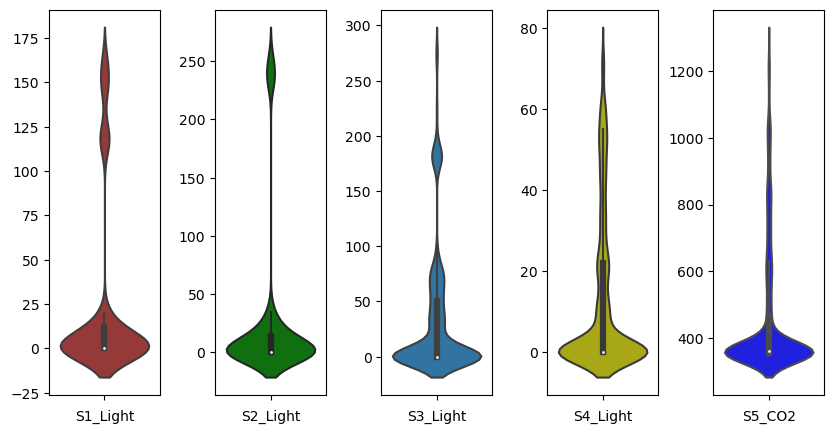

In [11]:
# Setting output to have 5 subplots in a single row
fig, ax = plt.subplots(1, 5, figsize=(10, 5))

# To tune the spacing between the subplots
plt.subplots_adjust(wspace=0.5) 

# Drawing boxplot for S1_Light in the 1st subplot
sns.violinplot(data=df['S1_Light'], ax=ax[0], color='brown')
ax[0].set_xlabel('S1_Light')

# Drawing boxplot for S2_Light in the 1st subplot
sns.violinplot(data=df['S2_Light'], ax=ax[1], color='g')
ax[1].set_xlabel('S2_Light')

# Drawing boxplot for S3_Light in the 1st subplot
sns.violinplot(data=df['S3_Light'], ax=ax[2])
ax[2].set_xlabel('S3_Light')

# Drawing boxplot for S4_Light in the 1st subplot
sns.violinplot(data=df['S4_Light'], ax=ax[3], color='y')
ax[3].set_xlabel('S4_Light')

# Drawing boxplot for S5_CO2 in the 1st subplot
sns.violinplot(data=df['S5_CO2'], ax=ax[4], color = 'b')
ax[4].set_xlabel('S5_CO2')

# by default, you'll see x-tick label set to 0 in each subplot
# remove it by setting it to empty list
for subplot in ax:
    subplot.set_xticklabels([])
    
plt.show()

##### Light:
There appear to be a lot of outliers for all light (lux) variables. From the violin plots, we can see that most of the density is around 0 for these variables. This suggests that there is no light source during those times. Typically, indoor light levels range between 100 and 300 for normal activities, which means that values above the 75th percentile are significant. Excluding these values solely based on their extremeness will lead to the loss of valuable information. 

#### CO2:

Here are the different CO2 levels which are considered typical and dangerous:

- 400ppm – Normal outdoor air level.
- 400 ~ 1,100ppm – Typical value level indoors with good ventilation. If CO2 levels are low when the building is sealed and occupied, check for over-ventilation (too much fresh air = energy wasted).
- 1,100ppm – the OSHA/ASHRAE recommended maximum level in a closed room.
- '> 1,200ppm'– Poor air quality – requires ventilation to the room.
- 2,000ppm – According to many studies this level of CO2 produces a significant increase in drowsiness, tiredness, headaches, lower levels of concentration, and an increased likelihood of spreading respiratory viruses like colds, etc.

From this we can conclude that the extreme values of the CO2 level add value to the dataset. Hence, we do not need to exclude the values here as well.

#### 4. Data Reduction

In [12]:
df['S5_CO2_Slope'] = np.round(df['S5_CO2_Slope'], decimals = 2)

In [13]:
df.head()

S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  S4_Light  \
0    24.94    24.75    24.56    25.38       121        34        53        40   
1    24.94    24.75    24.56    25.44       121        33        53        40   
2    25.00    24.75    24.50    25.44       121        34        53        40   
3    25.00    24.75    24.56    25.44       121        34        53        40   
4    25.00    24.75    24.56    25.44       121        34        54        40   

   S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  S6_PIR  \
0      0.08      0.19      0.06      0.06     390          0.77       0   
1      0.93      0.05      0.06      0.06     390          0.65       0   
2      0.43      0.11      0.08      0.06     390          0.52       0   
3      0.41      0.10      0.10      0.09     390          0.39       0   
4      0.18      0.06      0.06      0.06     390          0.25       0   

   S7_PIR  Room_Occupancy_Count  
0       0                     1  
1       0                     1  
2       0                     1  
3       0                     1  
4       0                     1

## Visualization Analysis

### 1. Pairplot

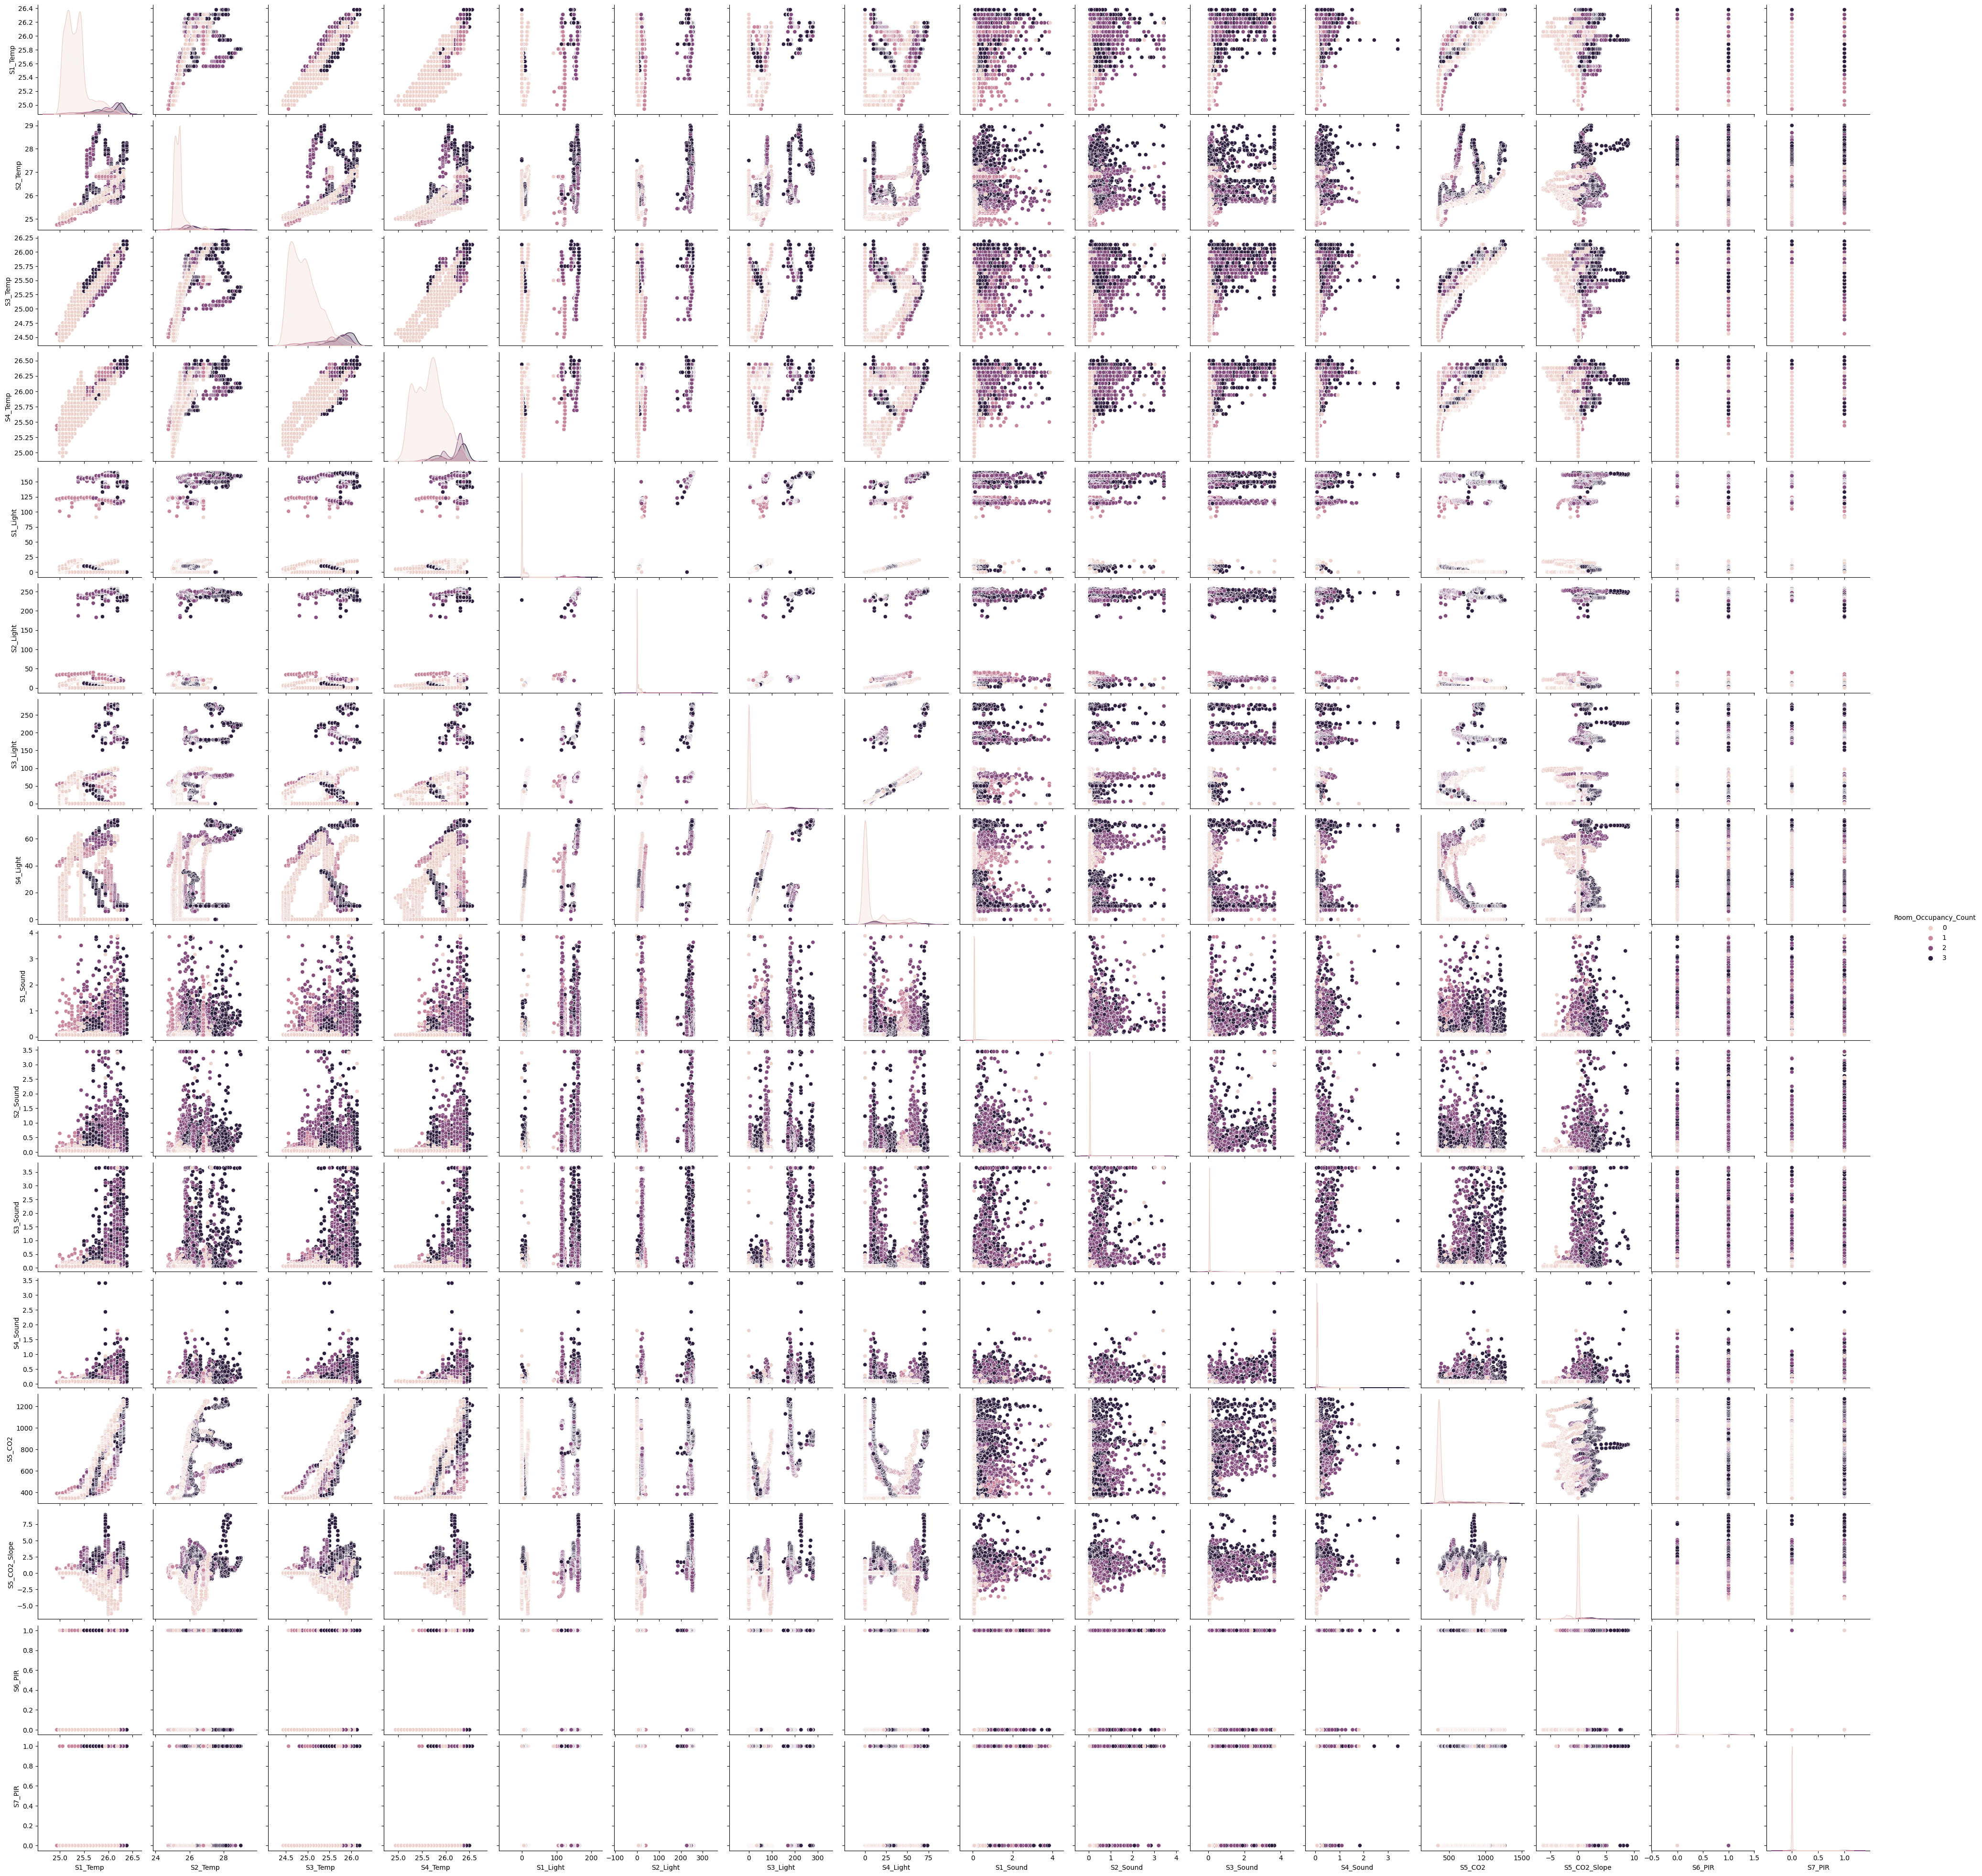

In [14]:
sns.pairplot(data=df, hue='Room_Occupancy_Count')

Through the pairplot we can tell pairwise linear relationships between two varibles in the dataset and also their distributions. Through these plots we can see that the the dataset is linearly seperable. We can further check this with the help of a correlation matrix.

### 2. Box-and-whisker Plot

This type of plot is commonly used to visualize relationships between numerical variables and categorical variables. 

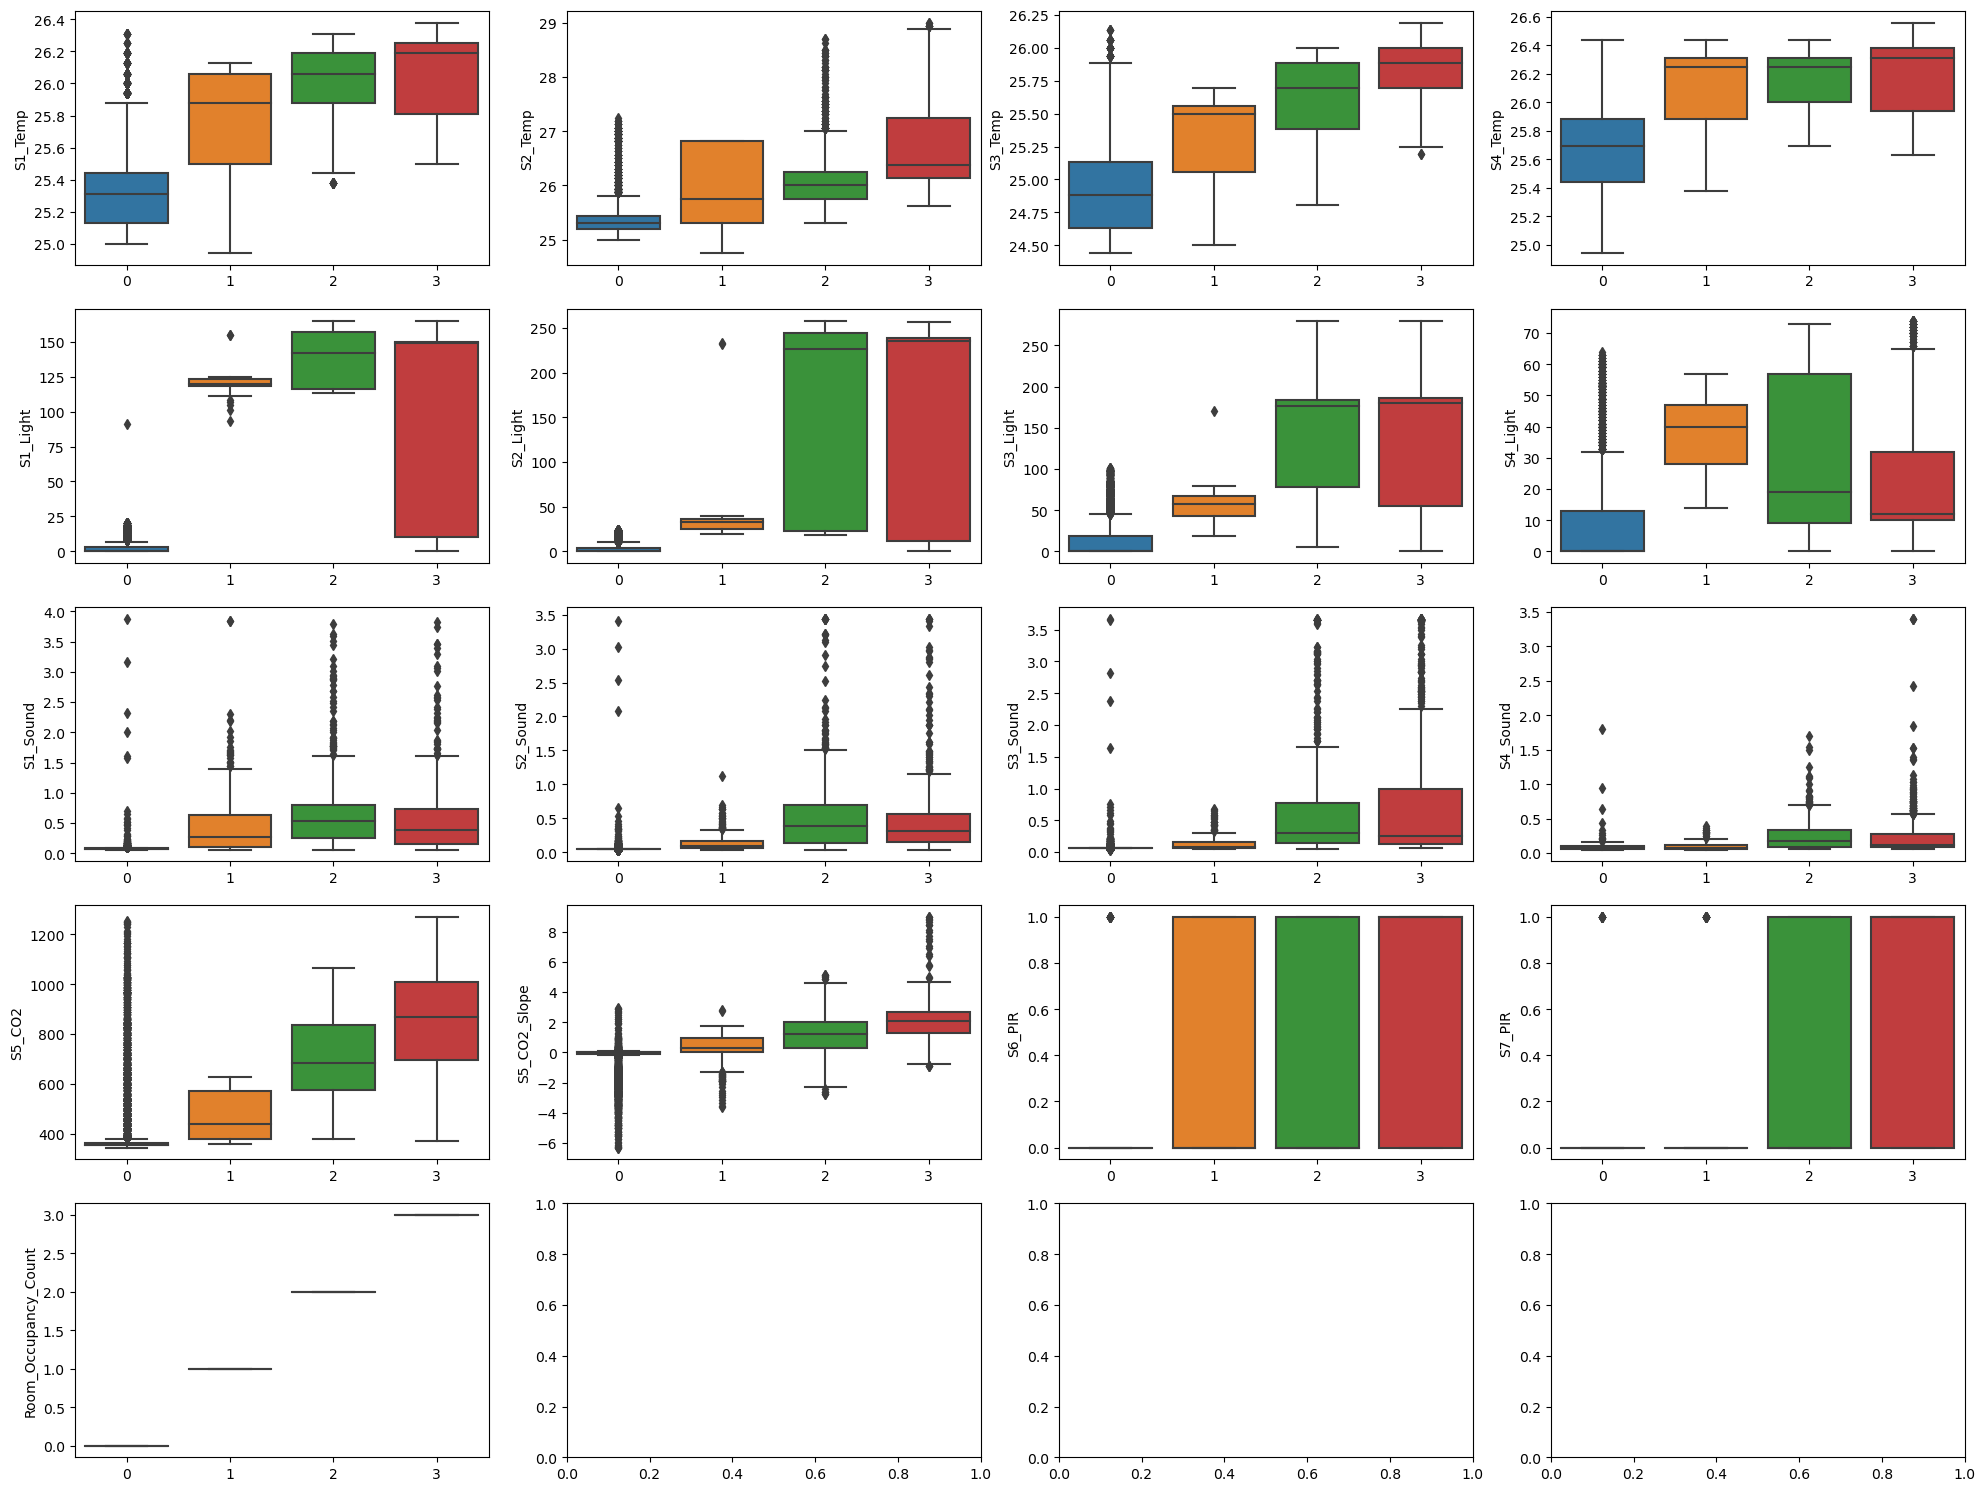

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
for idx, feat in enumerate(df.columns.to_list(), start=0):
    ax = axes[int(idx / 4), idx % 4]
    sns.boxplot(x="Room_Occupancy_Count", y=feat, data=df, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(feat)
fig.tight_layout();

Insights:

- The temperature increases when there are people present in the room. 
- All light variables have higher readings when the room is occupied. This should be an effective variable to estimate occupancy in a room.
- The sound variable seems to vary according to the number of occupants in the room but is generally higher with more than one occupant.
- The CO2 reading seems higher when there is no occupant. At first glance, these look like outliers. These abnormalities may be caused by plants inside and CO2-emitting equipment inside. Poor ventilation could also contribute to the problem. 
- As expected, motion is detected when occupants are in a room. This can also be a good variable to estimate room occupancy. 

<a href="#top">Back to top</a>
<a id="4"></a> 
## Part 4. Variable Selection :

### 1. Lasso Regression



In [16]:
X = df.drop(['Room_Occupancy_Count'], axis=1)
y = df[['Room_Occupancy_Count']]

In [17]:
# Scaling the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
lasso_reg = Lasso()
lasso_reg.fit(X_scaled, y)

Lasso()

In [19]:
%%time

# define grid search
grid = {
    "alpha": [0.0001, 0.001,0.01,0.1,1]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_search_lasso = GridSearchCV(estimator = lasso_reg, 
                                 param_grid=grid, 
                                 n_jobs=-1, 
                                 cv=cv, 
                                 scoring='accuracy', 
                                 error_score=0)

#Results
grid_result_lasso = grid_search_lasso.fit(X_scaled, y)

Wall time: 3.74 s


In [20]:
grid_result_lasso.best_params_

{'alpha': 0.0001}

In [21]:
coef = grid_result_lasso.best_estimator_.coef_
coef

array([ 0.04732832,  0.06805901,  0.3347066 , -0.24713725,  0.27356625,
        0.06027506,  0.15170874, -0.07879505,  0.03178407,  0.05189477,
       -0.03122681, -0.04182042,  0.0071826 ,  0.22085647,  0.05154466,
        0.11209123])

In [22]:
X.columns[coef == 0]

Index([], dtype='object')

An empty list shows that we could not eliminate any variables. It could also be inferred that all the variables are relevant to a certain extent according to lasso regression.

### 3. Correlation Matrix

The correlation matrix will help us find the relationship between all the possible variables in the dataset. Based on the correlation coefficients, we can determine a threshold for statistical significance and select variables with variables graeter values. 

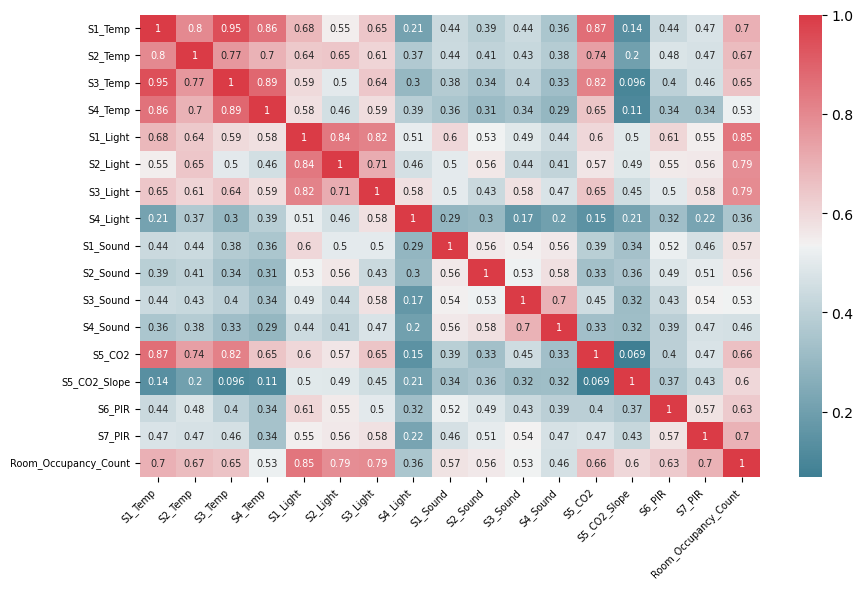

In [23]:
# Creating a correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            annot=True, 
            annot_kws={"fontsize":7}
           )
plt.xticks(rotation=45, ha='right', fontsize=7) 
plt.yticks(fontsize=7) 

plt.show()

In [24]:
df.shape

(10129, 17)

In [25]:
# Creating a function to return all variables that have good correlation coefficients

def get_correlated_variables(dataset, threshold):
    corr_columns = set() # To get unique correlated column names
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i][j]) > threshold:    # Checking the absolute value of the corr coeff
                column_name = corr_matrix.columns[i]       # Getting the name of the column
                corr_columns.add(column_name)
    return corr_columns

In [26]:
corr_features = get_correlated_variables(X, 0.8)
corr_features

{'S2_Light', 'S3_Light', 'S3_Temp', 'S4_Temp', 'S5_CO2'}

All the 3 models were run on variables selected through a correlation matrix, but they did not give good enough results. This could be because the correlation matrix measures the relationship between pairs of variables. It does not consider the impact they have on a target variable when other variables are included in the model. Due to this, a few variables may appear redundant in a correlation matrix but provide crucial information relevant to the target variable.

Further we try a wrapper method for variable selection.

### 3. Bi-Directional Elimination as a wrapper method

Wrapper method: This is a method of variable selection that trains and evaluates a machine learning algorithm for different subsets of features and determines the most suitable subset of features that yields the highest performance.

Here we use bi-directional elimination as a wrapper method on the "Random Forest Classifier". This wrapper method combines both forward selection and backward elimination methods. While adding a new feature, it checks the significance of already added features. If it finds any of the already selected features to be insignificant, it simply removes that particular feature through backward elimination.

In [27]:
%%time

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Bi-directional Sequential Selection(sffs)
sffs = SFS(RandomForestClassifier(),
           k_features = (1, len(X.columns)),
           forward = True,
           floating = True,
           scoring = 'accuracy',
           cv=5)
sffs.fit(X, y)
corr_features = list(sffs.k_feature_names_)
corr_features

Wall time: 8min 31s


['S1_Temp', 'S1_Light', 'S3_Light', 'S1_Sound', 'S5_CO2_Slope']

In [28]:
X_final = X[corr_features]
X_final.head()

S1_Temp  S1_Light  S3_Light  S1_Sound  S5_CO2_Slope
0    24.94       121        53      0.08          0.77
1    24.94       121        53      0.93          0.65
2    25.00       121        53      0.43          0.52
3    25.00       121        53      0.41          0.39
4    25.00       121        54      0.18          0.25

In [29]:
X_final.shape

(10129, 5)

<a href="#top">Back to top</a>
<a id="5"></a> 
## Part 5. HyperParameter Tuning and Model Selection :

In [30]:
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.25, random_state=42)

In [31]:
# Scaling the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1. Linear Classifier

In [32]:
sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(X_train_scaled, y_train)

print("Accuracy on train set: ", sgd_model.score(X_train_scaled, y_train))
print("Accuracy on test set: ", sgd_model.score(X_test_scaled, y_test))

Accuracy on train set:  0.9328593996840442

Accuracy on test set:  0.9281484405842874


In [33]:
%%time

#Defining hyperparameters
loss = ["hinge", "log", "squared_hinge", "modified_huber"]
penalty = ['l1','l2','elasticnet']
alpha = [0.0001, 0.001, 0.01, 0.1]
    
# define grid search
grid = dict(loss=loss, penalty=penalty, alpha=alpha)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_search = GridSearchCV(estimator=sgd_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)

#Results
grid_result = grid_search.fit(X_train_scaled, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.928164 using {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l1'}

0.924171 (0.006643) with: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1'}

0.921802 (0.009450) with: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}

0.922679 (0.006805) with: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'elasticnet'}

0.920835 (0.009339) with: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}

0.921626 (0.008643) with: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}

0.919870 (0.010834) with: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'elasticnet'}

0.900606 (0.011865) with: {'alpha': 0.0001, 'loss': 'squared_hinge', 'penalty': 'l1'}

0.900257 (0.026016) with: {'alpha': 0.0001, 'loss': 'squared_hinge', 'penalty': 'l2'}

0.903372 (0.021234) with: {'alpha': 0.0001, 'loss': 'squared_hinge', 'penalty': 'elasticnet'}

0.913200 (0.007615) with: {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l1'}

0.914691 (0.010489) with: {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l2'}

In [34]:
sgd_model = SGDClassifier(alpha=grid_result.best_params_['alpha'], 
                          loss= grid_result.best_params_['loss'], 
                          penalty= grid_result.best_params_['penalty'], 
                          random_state=42)
sgd_model.fit(X_train_scaled, y_train)

print("Accuracy on test set after hyperparameter tuning: ", sgd_model.score(X_test_scaled, y_test))

Accuracy on test set after hyperparameter tuning:  0.9218318199763127


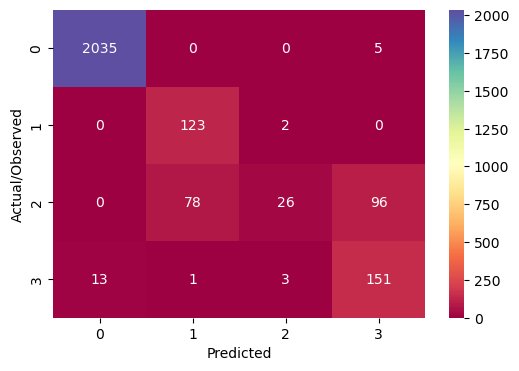

In [35]:
y_predict = sgd_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize = (6,4))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral",
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10);

In [36]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support



           0       0.99      1.00      1.00      2040

           1       0.61      0.98      0.75       125

           2       0.84      0.13      0.23       200

           3       0.60      0.90      0.72       168



    accuracy                           0.92      2533

   macro avg       0.76      0.75      0.67      2533

weighted avg       0.94      0.92      0.90      2533




In [37]:
# Calculating the evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
weighted_precision = precision_score(y_test, y_predict, average='weighted')
weighted_recall = recall_score(y_test, y_predict, average='weighted')
weighted_f1 = f1_score(y_test, y_predict, average='weighted')

# Creating an evaluation metrics dataframe for the model
results = pd.DataFrame([['Linear Classifier', 
                         round(accuracy*100,2), 
                         round(weighted_precision*100,2), 
                         round(weighted_recall*100,2), 
                         round(weighted_f1*100,2)
                        ]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results

Model  Accuracy  Precision  Recall  F1 Score
0  Linear Classifier     92.18      93.63   92.18     90.44

### 2. KNN Classifier

In [38]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train_scaled, y_train)

print("Accuracy on train set: ", knn_model.score(X_train_scaled, y_train))
print("Accuracy on test set: ", knn_model.score(X_test_scaled, y_test))

Accuracy on train set:  0.9926276987888363

Accuracy on test set:  0.9865771812080537


In [39]:
%%time

# define grid search
grid = {
    "n_neighbors" : range(1, 20),
    "weights" : ['uniform', 'distance'],
    "p" : [1,2]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=knn_model, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = cv, 
                           scoring = 'accuracy',
                           error_score = 0,
                           verbose = 1
                          )

grid_result = grid_search.fit(X_train_scaled, y_train)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 15 folds for each of 76 candidates, totalling 1140 fits

Best: 0.993154 using {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

0.992891 (0.001941) with: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

0.992891 (0.001941) with: {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}

0.991004 (0.002212) with: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

0.991004 (0.002212) with: {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}

0.990565 (0.002506) with: {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}

0.992891 (0.001941) with: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}

0.988371 (0.002290) with: {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}

0.991004 (0.002212) with: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

0.993023 (0.001827) with: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

0.993154 (0.001644) with: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

0.990960 (0.001758) with: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

0.991092 (0.001748) wi

In [40]:
knn_model = KNeighborsClassifier(n_neighbors= grid_result.best_params_['n_neighbors'], 
                                 p= grid_result.best_params_['p'], 
                                 weights= grid_result.best_params_['weights'])
knn_model.fit(X_train_scaled, y_train)

print("Accuracy on test set: ", knn_model.score(X_test_scaled, y_test))

Accuracy on test set:  0.9936833793920252


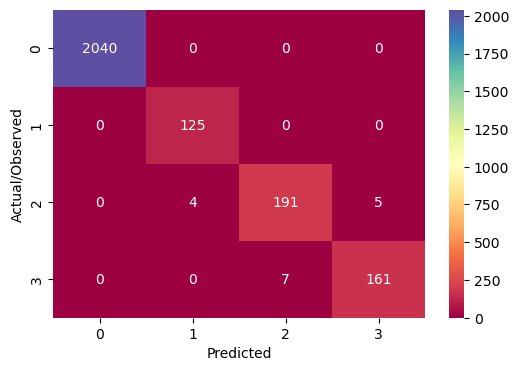

In [41]:
y_pred = knn_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6,4))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral",
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10);

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2040

           1       0.97      1.00      0.98       125

           2       0.96      0.95      0.96       200

           3       0.97      0.96      0.96       168



    accuracy                           0.99      2533

   macro avg       0.98      0.98      0.98      2533

weighted avg       0.99      0.99      0.99      2533




In [43]:
# Calculating the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Creating an evaluation metrics dataframe for the model
lr_results = pd.DataFrame([['KNN Classifier', 
                         round(accuracy*100,2), 
                         round(weighted_precision*100,2), 
                         round(weighted_recall*100,2), 
                         round(weighted_f1*100,2)
                        ]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Appending the evaluation metrics into a dataframe
results = results.append(lr_results, ignore_index = True)

results

Model  Accuracy  Precision  Recall  F1 Score
0  Linear Classifier     92.18      93.63   92.18     90.44
1     KNN Classifier     99.37      99.37   99.37     99.37

### 3. Random Forest

In [44]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

print("Accuracy on train set: ", rf_model.score(X_train_scaled, y_train))
print("Accuracy on test set: ", rf_model.score(X_test_scaled, y_test))

Accuracy on train set:  1.0

Accuracy on test set:  0.9964469009080142


In [45]:
%%time

# define grid search
grid = {
    "bootstrap" : ['True'],
    "max_features" : ['sqrt', 'log2'],
    "max_depth": [10,20,30,40,50],
    "n_estimators": [100,200,300,400,500]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = cv, 
                           scoring = 'accuracy',
                           error_score = 0,
                           verbose = 1
                          )

grid_result = grid_search.fit(X_test_scaled, y_test)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 15 folds for each of 50 candidates, totalling 750 fits

Best: 0.996447 using {'bootstrap': 'True', 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}

0.995921 (0.002216) with: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}

0.995921 (0.002096) with: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}

0.995921 (0.002216) with: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}

0.996052 (0.002161) with: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 400}

0.996184 (0.001832) with: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}

0.996052 (0.001906) with: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}

0.996052 (0.002161) with: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}

0.996052 (0.001906) with: {'bootstrap': 'True', 'max_

In [46]:
rf_model = RandomForestClassifier(bootstrap= 'True', 
                                  max_depth= grid_result.best_params_['max_depth'], 
                                  max_features= grid_result.best_params_['max_features'], 
                                  n_estimators= grid_result.best_params_['n_estimators'])
rf_model.fit(X_train_scaled, y_train)

print("Accuracy on test set: ", rf_model.score(X_test_scaled, y_test))

Accuracy on test set:  0.9960521121200158


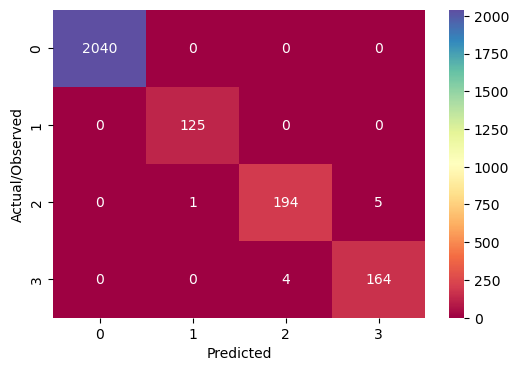

In [47]:
y_pred = rf_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6,4))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral",
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10);

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2040

           1       0.99      1.00      1.00       125

           2       0.98      0.97      0.97       200

           3       0.97      0.98      0.97       168



    accuracy                           1.00      2533

   macro avg       0.99      0.99      0.99      2533

weighted avg       1.00      1.00      1.00      2533




In [49]:
# Calculating the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Creating an evaluation metrics dataframe for the model
lr_results = pd.DataFrame([['Random Forest', 
                         round(accuracy*100,2), 
                         round(weighted_precision*100,2), 
                         round(weighted_recall*100,2), 
                         round(weighted_f1*100,2)
                        ]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Appending the evaluation metrics into a dataframe
results = results.append(lr_results, ignore_index = True)

results

Model  Accuracy  Precision  Recall  F1 Score
0  Linear Classifier     92.18      93.63   92.18     90.44
1     KNN Classifier     99.37      99.37   99.37     99.37
2      Random Forest     99.61      99.61   99.61     99.60

Random Forest performs the best with the selected variables. 